# Exercise 6 – Classification: Solution Template

This notebook provides a **structured, commented solution** for:

**ProgDS-2025-10-14 – Exercise 6: Classification**

---

## 🔹 Problem Statement (as per assignment)

You will be processing the following datasets:

- `Clusters-4-v0.csv`  
- `Clusters-4-v1.csv`  
- `Clusters-4-v2.csv`  

### Part 1

1. **Train–Test Split**  
   Divide each dataset into **train** and **test** datasets **once**, and use the same split for all subsequent steps.

2. **Data Review & Intuition**  
   Review each dataset using appropriate plots and understand the overall structure of the data.  
   Comment on the data and **anticipate how well Logistic Regression will perform**.

3. **Algorithms to Use**  
   For each dataset, use the following algorithms / variants:

   a. Logistic Regression  
   b. Logistic Regression **after adding polynomial features**  
   c. SVC – with `'linear'` kernel (**what is “linear”?**)  
   d. SVC – with `'rbf'` kernel (**what is “rbf”?**)  
   e. Random Forest Classifier – for various combinations of:  
      - `min_samples_leaf` = 1 to 5  
      - `max_depth` = 2 to 5  
      Treat this as a **grid search** problem – create a model for every combination.  
   f. Neural Network Classifier – `hidden_layer_sizes=(5,)`  
   g. Neural Network Classifier – `hidden_layer_sizes=(5,5)`  
   h. Neural Network Classifier – `hidden_layer_sizes=(5,5,5)`  
   i. Neural Network Classifier – `hidden_layer_sizes=(10,)`  

4. **Metrics Collection**  
   In each of the above cases, generate, capture, and save all the results, for all the datasets, into a **common CSV file** – to facilitate analysis later on.  
   For **train and test** data, create the following metrics:

   - Accuracy  
   - Precision (per class)  
   - Precision (average)  
   - Recall (per class)  
   - Recall (average)  
   - F1-score (per class)  
   - F1-score (average)  
   - AUC (per class)  
   - AUC (average)  

5. **Decision Boundary Plots**  
   For each dataset, generate decision-boundary plots – to understand the classification boundaries and overall performance of the classifiers.

6. **Comparison & Discussion**  
   Compare the metrics **within and across** datasets (train and test) and algorithms.  
   Discuss: classification boundaries, overfitting, sensitivity to parameters, etc.

---

Below, the notebook is structured to **answer each of the above points step by step**, with clear comments.


In [1]:
# ---------------------------------------------------------
# 1. Import all required libraries
# ---------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# For nicer plots
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['axes.grid'] = True


## Step 1 – Load the three datasets

We load:

- `Clusters-4-v0.csv`  
- `Clusters-4-v1.csv`  
- `Clusters-4-v2.csv`  

and store them in a dictionary for easy looping.


In [2]:
# ---------------------------------------------------------
# 2. Load all three datasets
# ---------------------------------------------------------

# NOTE: Make sure these CSV files are in the same folder as this notebook.
dataset_files = {
    "v0": "/content/sample_data/clusters-4-v0.csv",
    "v1": "/content/sample_data/clusters-4-v1.csv",
    "v2": "/content/sample_data/clusters-4-v2.csv"
}

datasets = {}

for name, filename in dataset_files.items():
    df = pd.read_csv(filename)
    datasets[name] = df
    print(f"Loaded {name}: shape = {df.shape}")


Loaded v0: shape = (1440, 3)
Loaded v1: shape = (1440, 3)
Loaded v2: shape = (1440, 3)


## Step 2 – Train–Test split (once per dataset)

For each dataset, we:

- Separate features `X` and labels `y`.  
- Use `train_test_split` **once** with a fixed `random_state`.  
- Store the split so that all algorithms use the same train–test division.


In [3]:
# ---------------------------------------------------------
# 3. Create and store train–test splits for each dataset
# ---------------------------------------------------------

splits = {}

test_size = 0.25
random_state = 42

for name, df in datasets.items():
    # Assumption: last column is the class label
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    splits[name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

    print(f"Dataset {name}: train = {X_train.shape}, test = {X_test.shape}")


Dataset v0: train = (1080, 2), test = (360, 2)
Dataset v1: train = (1080, 2), test = (360, 2)
Dataset v2: train = (1080, 2), test = (360, 2)


## Step 3 – Data review & intuition (Logistic Regression)

In this step, you can:

- Plot the scatter of the two features coloured by the class label.  
- Visually inspect how “linearly separable” the classes appear.  
- Based on this, **comment on expected Logistic Regression performance**.

Below is a helper function and example usage for one dataset; you can repeat it for others.


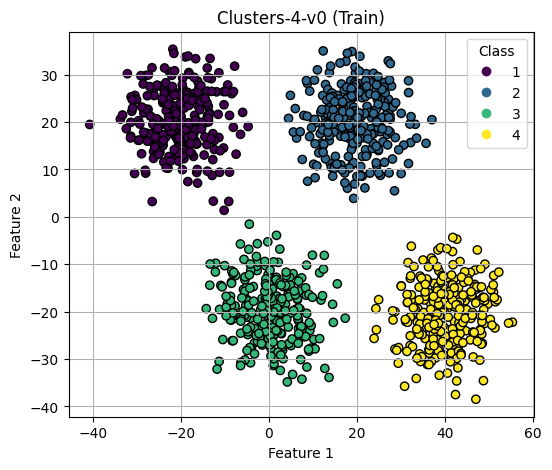

In [4]:
# ---------------------------------------------------------
# 4. Simple visualization function for 2D cluster datasets
# ---------------------------------------------------------

def plot_dataset_scatter(X, y, title="Dataset"):
    """Scatter plot of a 2D dataset with color-coded classes."""
    plt.figure()
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Class", loc="best")
    plt.show()


# Example: Visualize v0 train data and comment on linear separability
X_train_v0 = splits["v0"]["X_train"]
y_train_v0 = splits["v0"]["y_train"]

plot_dataset_scatter(X_train_v0, y_train_v0, title="Clusters-4-v0 (Train)")

# TODO (for learners / instructors):
# - Run this for v1 and v2 as well.
# - Based on how "nicely" the clusters are separated by straight lines,
#   comment on whether Logistic Regression is expected to perform well or poorly.


## Step 4 – Define all required algorithms (as per assignment)

For each dataset, we will train the following models:

1. **Logistic Regression**  
2. **Polynomial Logistic Regression** (using PolynomialFeatures on the inputs)  
3. **SVC (linear kernel)**  
4. **SVC (RBF kernel)**  
5. **Random Forest Classifier** for a grid of:
   - `min_samples_leaf` = 1, 2, 3, 4, 5  
   - `max_depth` = 2, 3, 4, 5  
6. **Neural Network Classifiers** with:
   - `(5,)`  
   - `(5,5)`  
   - `(5,5,5)`  
   - `(10,)`

We will create a function that, given **X_train** and **X_test**, returns an ordered dictionary of instantiated models.


In [5]:
# ---------------------------------------------------------
# 5. Define all required algorithms
# ---------------------------------------------------------

from collections import OrderedDict

def get_models_for_dataset(X_train):
    """Return all models required by the assignment in an OrderedDict.

    Note: Polynomial Logistic Regression uses PolynomialFeatures on the *inputs*.
    """
    models = OrderedDict()

    # 1. Logistic Regression (on original features)
    models["LogReg"] = ("plain", LogisticRegression(max_iter=5000))

    # 2. Logistic Regression with Polynomial Features (degree=3 as an example)
    #    We will handle the PolynomialFeatures transformation outside when training.
    models["PolyLogReg_deg3"] = ("poly3", LogisticRegression(max_iter=5000))

    # 3. SVC - linear kernel
    models["SVC_linear"] = ("plain", SVC(kernel="linear", probability=True))

    # 4. SVC - RBF kernel
    models["SVC_rbf"] = ("plain", SVC(kernel="rbf", probability=True))

    # 5. Random Forest - grid search over min_samples_leaf and max_depth
    for leaf in range(1, 6):          # 1 to 5
        for depth in range(2, 6):      # 2 to 5
            name = f"RF_leaf{leaf}_depth{depth}"
            rf = RandomForestClassifier(
                n_estimators=200,
                min_samples_leaf=leaf,
                max_depth=depth,
                random_state=42
            )
            models[name] = ("plain", rf)

    # 6. Neural Networks - different hidden_layer_sizes
    nn_configs = {
        "NN_5": (5,),
        "NN_5_5": (5, 5),
        "NN_5_5_5": (5, 5, 5),
        "NN_10": (10,)
    }

    for name, hidden in nn_configs.items():
        clf = MLPClassifier(hidden_layer_sizes=hidden, max_iter=10000, random_state=42)
        models[name] = ("scaled", clf)
        # We'll use scaled inputs for NNs, handled outside this function.

    return models


## Step 5 – Metric computation helper

We now create a helper function that:

- Trains a model on `X_train`, `y_train`.  
- Predicts on train and test.  
- Computes all required metrics for **each class** and **macro averages**:

  - Accuracy  
  - Precision (per class + macro)  
  - Recall (per class + macro)  
  - F1 (per class + macro)  
  - AUC (per class + macro)

The results will be stored in a list of dictionaries, which we later convert to a DataFrame and save as a single CSV.


In [8]:
# ---------------------------------------------------------
# 6. Helper for metric computation  (CORRECTED VERSION)
# ---------------------------------------------------------

def compute_metrics_for_model(model, X_train, X_test, y_train, y_test, label_classes):
    """
    Train the model and compute all required metrics.

    Returns a list of metric dicts: one per class + one for macro-average.

    Assumes:
    - model has .fit(), .predict(), and .predict_proba() methods
    - label_classes is a sorted list/array of unique class labels
    """
    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --------- Accuracy (single value for whole dataset) ---------
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # --------- Precision, Recall, F1 per class ---------
    prec_train_per_class = precision_score(
        y_train, y_pred_train, average=None, labels=label_classes
    )
    prec_test_per_class = precision_score(
        y_test, y_pred_test, average=None, labels=label_classes
    )

    rec_train_per_class = recall_score(
        y_train, y_pred_train, average=None, labels=label_classes
    )
    rec_test_per_class = recall_score(
        y_test, y_pred_test, average=None, labels=label_classes
    )

    f1_train_per_class = f1_score(
        y_train, y_pred_train, average=None, labels=label_classes
    )
    f1_test_per_class = f1_score(
        y_test, y_pred_test, average=None, labels=label_classes
    )

    # --------- Macro averages ---------
    prec_train_macro = precision_score(y_train, y_pred_train, average="macro")
    prec_test_macro = precision_score(y_test, y_pred_test, average="macro")

    rec_train_macro = recall_score(y_train, y_pred_train, average="macro")
    rec_test_macro = recall_score(y_test, y_pred_test, average="macro")

    f1_train_macro = f1_score(y_train, y_pred_train, average="macro")
    f1_test_macro = f1_score(y_test, y_pred_test, average="macro")

    # --------- AUC (needs probabilities) ---------
    # For multi-class, we use one-vs-rest
    y_score_train = model.predict_proba(X_train)
    y_score_test = model.predict_proba(X_test)

    # Macro AUC (multi-class OVR)
    auc_train_macro = roc_auc_score(
        y_train, y_score_train, multi_class="ovr", average="macro"
    )
    auc_test_macro = roc_auc_score(
        y_test, y_score_test, multi_class="ovr", average="macro"
    )

    # Per-class AUC (CORRECTED LOOP)
    auc_train_per_class = []
    auc_test_per_class = []

    # IMPORTANT: use index (0,1,2,...) to index columns of y_score,
    # not the raw class label value.
    for idx, cls in enumerate(label_classes):
        # Binary ground truth for this class (one-vs-rest)
        y_train_bin = (y_train == cls).astype(int)
        y_test_bin = (y_test == cls).astype(int)

        # Use the probability column corresponding to this class index
        y_score_train_bin = y_score_train[:, idx]
        y_score_test_bin = y_score_test[:, idx]

        auc_train_cls = roc_auc_score(y_train_bin, y_score_train_bin)
        auc_test_cls = roc_auc_score(y_test_bin, y_score_test_bin)

        auc_train_per_class.append(auc_train_cls)
        auc_test_per_class.append(auc_test_cls)

    # --------- Build output rows ---------
    rows = []

    # Per-class rows
    for i, cls in enumerate(label_classes):
        rows.append({
            "level": "per_class",
            "class": cls,
            "accuracy_train": acc_train,
            "accuracy_test": acc_test,
            "precision_train": prec_train_per_class[i],
            "precision_test": prec_test_per_class[i],
            "recall_train": rec_train_per_class[i],
            "recall_test": rec_test_per_class[i],
            "f1_train": f1_train_per_class[i],
            "f1_test": f1_test_per_class[i],
            "auc_train": auc_train_per_class[i],
            "auc_test": auc_test_per_class[i],
        })

    # Macro-average row
    rows.append({
        "level": "macro",
        "class": "macro",
        "accuracy_train": acc_train,
        "accuracy_test": acc_test,
        "precision_train": prec_train_macro,
        "precision_test": prec_test_macro,
        "recall_train": rec_train_macro,
        "recall_test": rec_test_macro,
        "f1_train": f1_train_macro,
        "f1_test": f1_test_macro,
        "auc_train": auc_train_macro,
        "auc_test": auc_test_macro,
    })

    return rows


## Step 6 – Train all models on all datasets and collect metrics

Now we:

- Loop over each dataset (`v0`, `v1`, `v2`).  
- Get all models by calling `get_models_for_dataset`.  
- For each model:
  - Apply any required preprocessing (polynomial features, scaling).  
  - Train the model and compute all metrics using `compute_metrics_for_model`.  
- Store everything in a single DataFrame and save to a **CSV file** (one file for all datasets and models).


In [9]:
# ---------------------------------------------------------
# 7. Train all models on all datasets and collect metrics
# ---------------------------------------------------------

all_rows = []

for dataset_name, split in splits.items():
    print(f"\n=== Processing dataset: {dataset_name} ===")

    X_train = split["X_train"]
    X_test = split["X_test"]
    y_train = split["y_train"]
    y_test = split["y_test"]

    # Unique classes (needed for per-class metrics)
    classes = np.unique(y_train)

    # Prepare polynomial features transformer for this dataset (degree=3 as example)
    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Prepare scaler for NN models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = get_models_for_dataset(X_train)

    for model_name, (input_type, model) in models.items():
        print(f"  -> Training model: {model_name}")

        # Decide which input representation to use
        if model_name.startswith("PolyLogReg"):
            Xtr, Xte = X_train_poly, X_test_poly
        elif input_type == "scaled":
            Xtr, Xte = X_train_scaled, X_test_scaled
        else:
            Xtr, Xte = X_train, X_test

        rows = compute_metrics_for_model(
            model=model,
            X_train=Xtr,
            X_test=Xte,
            y_train=y_train,
            y_test=y_test,
            label_classes=classes
        )

        # Add metadata (dataset, model) to each row
        for r in rows:
            r["dataset"] = dataset_name
            r["model"] = model_name

        all_rows.extend(rows)

# Convert to DataFrame and save
df_metrics = pd.DataFrame(all_rows)
df_metrics.to_csv("exercise6_all_results.csv", index=False)
df_metrics.head()



=== Processing dataset: v0 ===
  -> Training model: LogReg
  -> Training model: PolyLogReg_deg3
  -> Training model: SVC_linear
  -> Training model: SVC_rbf
  -> Training model: RF_leaf1_depth2
  -> Training model: RF_leaf1_depth3
  -> Training model: RF_leaf1_depth4
  -> Training model: RF_leaf1_depth5
  -> Training model: RF_leaf2_depth2
  -> Training model: RF_leaf2_depth3
  -> Training model: RF_leaf2_depth4
  -> Training model: RF_leaf2_depth5
  -> Training model: RF_leaf3_depth2
  -> Training model: RF_leaf3_depth3
  -> Training model: RF_leaf3_depth4
  -> Training model: RF_leaf3_depth5
  -> Training model: RF_leaf4_depth2
  -> Training model: RF_leaf4_depth3
  -> Training model: RF_leaf4_depth4
  -> Training model: RF_leaf4_depth5
  -> Training model: RF_leaf5_depth2
  -> Training model: RF_leaf5_depth3
  -> Training model: RF_leaf5_depth4
  -> Training model: RF_leaf5_depth5
  -> Training model: NN_5
  -> Training model: NN_5_5
  -> Training model: NN_5_5_5
  -> Training mode

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  -> Training model: SVC_linear
  -> Training model: SVC_rbf
  -> Training model: RF_leaf1_depth2
  -> Training model: RF_leaf1_depth3
  -> Training model: RF_leaf1_depth4
  -> Training model: RF_leaf1_depth5
  -> Training model: RF_leaf2_depth2
  -> Training model: RF_leaf2_depth3
  -> Training model: RF_leaf2_depth4
  -> Training model: RF_leaf2_depth5
  -> Training model: RF_leaf3_depth2
  -> Training model: RF_leaf3_depth3
  -> Training model: RF_leaf3_depth4
  -> Training model: RF_leaf3_depth5
  -> Training model: RF_leaf4_depth2
  -> Training model: RF_leaf4_depth3
  -> Training model: RF_leaf4_depth4
  -> Training model: RF_leaf4_depth5
  -> Training model: RF_leaf5_depth2
  -> Training model: RF_leaf5_depth3
  -> Training model: RF_leaf5_depth4
  -> Training model: RF_leaf5_depth5
  -> Training model: NN_5
  -> Training model: NN_5_5
  -> Training model: NN_5_5_5
  -> Training model: NN_10

=== Processing dataset: v2 ===
  -> Training model: LogReg
  -> Training model: PolyLog

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  -> Training model: SVC_linear
  -> Training model: SVC_rbf
  -> Training model: RF_leaf1_depth2
  -> Training model: RF_leaf1_depth3
  -> Training model: RF_leaf1_depth4
  -> Training model: RF_leaf1_depth5
  -> Training model: RF_leaf2_depth2
  -> Training model: RF_leaf2_depth3
  -> Training model: RF_leaf2_depth4
  -> Training model: RF_leaf2_depth5
  -> Training model: RF_leaf3_depth2
  -> Training model: RF_leaf3_depth3
  -> Training model: RF_leaf3_depth4
  -> Training model: RF_leaf3_depth5
  -> Training model: RF_leaf4_depth2
  -> Training model: RF_leaf4_depth3
  -> Training model: RF_leaf4_depth4
  -> Training model: RF_leaf4_depth5
  -> Training model: RF_leaf5_depth2
  -> Training model: RF_leaf5_depth3
  -> Training model: RF_leaf5_depth4
  -> Training model: RF_leaf5_depth5
  -> Training model: NN_5
  -> Training model: NN_5_5
  -> Training model: NN_5_5_5
  -> Training model: NN_10


,level,class,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,dataset,model
0,per_class,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
1,per_class,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
2,per_class,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
3,per_class,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
4,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg


## Step 7 – Decision boundary plots (per dataset, per model)

To satisfy the requirement of **visualizing classification boundaries**, we define a helper:

- It will draw the decision surface (using a meshgrid over feature 1 & 2).  
- Then overlay the train and test points.  
- You can call this function for any classifier and dataset where features are 2D.


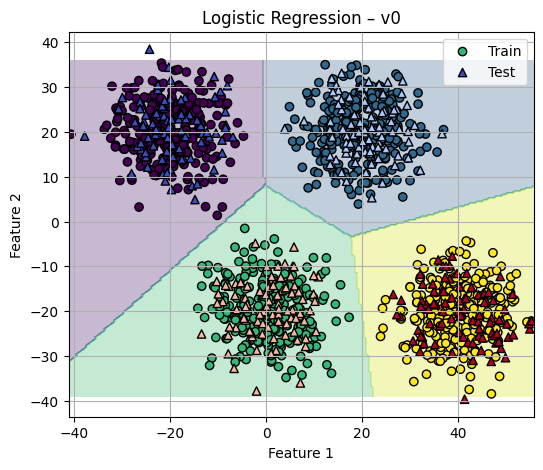

In [10]:
# ---------------------------------------------------------
# 8. Helper for decision boundary plots
# ---------------------------------------------------------

def plot_decision_boundary(model, X_train, y_train, X_test, y_test, title="Decision boundary"):
    """Plot decision boundary for a 2D classifier with train + test points."""
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    # For models that expect scaled or polynomial features, transform before calling this
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap='viridis', label="Train")
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', cmap='coolwarm', marker='^', label="Test")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()


# Example usage (for one dataset and model, e.g., Logistic Regression on v0):

# 1. Refit a simple model on v0 original features
example_split = splits["v0"]
X_train_v0 = example_split["X_train"]
X_test_v0 = example_split["X_test"]
y_train_v0 = example_split["y_train"]
y_test_v0 = example_split["y_test"]

example_model = LogisticRegression(max_iter=5000)
example_model.fit(X_train_v0, y_train_v0)

plot_decision_boundary(
    model=example_model,
    X_train=X_train_v0,
    y_train=y_train_v0,
    X_test=X_test_v0,
    y_test=y_test_v0,
    title="Logistic Regression – v0"
)

# TODO:
# - Repeat for SVC linear/RBF, Random Forest (chosen configuration), and NNs.
# - Repeat for v1 and v2 datasets.


## Step 8 – Compare metrics and discuss classifier behaviour

At this stage, you have:

- A CSV: `exercise6_all_results.csv` with **all** metrics for **all** models and datasets.  
- Decision boundary plots for selected models on each dataset.

You should now:

1. **Load the CSV** and perform simple comparisons:
   - Which models have the highest **test accuracy**?  
   - Do some models show high **train accuracy** but lower **test accuracy** (overfitting)?  
   - How does performance differ between `v0`, `v1`, `v2`?  

2. **Relate metrics to decision boundaries:**
   - For models with very wiggly / complex boundaries (e.g., certain RF or NN configs), do you observe overfitting?  
   - Does SVC with RBF capture non-linear boundaries better than Logistic Regression?  

3. **Write a short summary** of:
   - Which models you would prefer for each dataset and **why**.  
   - What you learned about:
     - Polynomial Logistic Regression  
     - Linear vs RBF kernels in SVC  
     - Grid search over Random Forest parameters  
     - NN depth and overfitting  


In [11]:
# ---------------------------------------------------------
# 9. Load metrics CSV and compare classifier behaviour
# ---------------------------------------------------------

# 1. Load the consolidated results
df_metrics = pd.read_csv("exercise6_all_results.csv")
print("Shape of metrics table:", df_metrics.shape)
df_metrics.head()


Shape of metrics table: (420, 14)


,level,class,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,dataset,model
0,per_class,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
1,per_class,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
2,per_class,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
3,per_class,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
4,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg


In [12]:
# 2. Quick sanity check: which datasets and models are present?
print("Datasets:", df_metrics["dataset"].unique())
print("\nModels:", df_metrics["model"].unique())
print("\nLevels:", df_metrics["level"].unique())  # 'per_class' and 'macro'


Datasets: ['v0' 'v1' 'v2']

Models: ['LogReg' 'PolyLogReg_deg3' 'SVC_linear' 'SVC_rbf' 'RF_leaf1_depth2'
 'RF_leaf1_depth3' 'RF_leaf1_depth4' 'RF_leaf1_depth5' 'RF_leaf2_depth2'
 'RF_leaf2_depth3' 'RF_leaf2_depth4' 'RF_leaf2_depth5' 'RF_leaf3_depth2'
 'RF_leaf3_depth3' 'RF_leaf3_depth4' 'RF_leaf3_depth5' 'RF_leaf4_depth2'
 'RF_leaf4_depth3' 'RF_leaf4_depth4' 'RF_leaf4_depth5' 'RF_leaf5_depth2'
 'RF_leaf5_depth3' 'RF_leaf5_depth4' 'RF_leaf5_depth5' 'NN_5' 'NN_5_5'
 'NN_5_5_5' 'NN_10']

Levels: ['per_class' 'macro']


In [13]:
# 3. Focus on macro rows only (one row per dataset+model)
macro_df = df_metrics[df_metrics["level"] == "macro"].copy()
macro_df.head()


,level,class,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test,dataset,model
4,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,LogReg
9,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,PolyLogReg_deg3
14,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,SVC_linear
19,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,SVC_rbf
24,macro,macro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,v0,RF_leaf1_depth2


In [14]:
# 4. For each dataset, show top models by TEST accuracy (macro row)
for d in macro_df["dataset"].unique():
    print(f"\n=== Top models by test accuracy – dataset {d} ===")
    display(
        macro_df[macro_df["dataset"] == d]
        .sort_values("accuracy_test", ascending=False)
        [["model", "accuracy_train", "accuracy_test",
          "f1_train", "f1_test", "auc_train", "auc_test"]]
        .head(10)
    )



=== Top models by test accuracy – dataset v0 ===


,model,accuracy_train,accuracy_test,f1_train,f1_test,auc_train,auc_test
4,LogReg,1.0,1.0,1.0,1.0,1.0,1.0
9,PolyLogReg_deg3,1.0,1.0,1.0,1.0,1.0,1.0
14,SVC_linear,1.0,1.0,1.0,1.0,1.0,1.0
19,SVC_rbf,1.0,1.0,1.0,1.0,1.0,1.0
24,RF_leaf1_depth2,1.0,1.0,1.0,1.0,1.0,1.0
29,RF_leaf1_depth3,1.0,1.0,1.0,1.0,1.0,1.0
34,RF_leaf1_depth4,1.0,1.0,1.0,1.0,1.0,1.0
39,RF_leaf1_depth5,1.0,1.0,1.0,1.0,1.0,1.0
44,RF_leaf2_depth2,1.0,1.0,1.0,1.0,1.0,1.0
49,RF_leaf2_depth3,1.0,1.0,1.0,1.0,1.0,1.0



=== Top models by test accuracy – dataset v1 ===


,model,accuracy_train,accuracy_test,f1_train,f1_test,auc_train,auc_test
154,SVC_linear,0.951852,0.955556,0.951893,0.955514,0.995668,0.995895
144,LogReg,0.951852,0.952778,0.951861,0.952749,0.995728,0.995885
159,SVC_rbf,0.953704,0.952778,0.953765,0.952749,0.995818,0.994938
199,RF_leaf2_depth5,0.962963,0.950000,0.962952,0.950083,0.998544,0.995617
259,RF_leaf5_depth5,0.960185,0.950000,0.960161,0.950200,0.997997,0.995648
274,NN_5_5_5,0.943519,0.950000,0.943427,0.949821,0.994634,0.994990
194,RF_leaf2_depth4,0.960185,0.947222,0.960156,0.947329,0.997556,0.995874
179,RF_leaf1_depth5,0.967593,0.947222,0.967588,0.947380,0.998785,0.995679
214,RF_leaf3_depth4,0.960185,0.947222,0.960156,0.947329,0.997466,0.995586
219,RF_leaf3_depth5,0.961111,0.947222,0.961096,0.947380,0.998363,0.995751



=== Top models by test accuracy – dataset v2 ===


,model,accuracy_train,accuracy_test,f1_train,f1_test,auc_train,auc_test
294,SVC_linear,0.861111,0.877778,0.860918,0.877606,0.969209,0.972963
414,NN_5_5_5,0.861111,0.877778,0.861018,0.877624,0.969877,0.972716
419,NN_10,0.861111,0.875000,0.860787,0.874355,0.969921,0.972500
299,SVC_rbf,0.861111,0.872222,0.861039,0.871967,0.969979,0.971512
409,NN_5_5,0.858333,0.872222,0.857985,0.871906,0.968681,0.969763
284,LogReg,0.861111,0.869444,0.860670,0.869031,0.969847,0.972737
359,RF_leaf3_depth5,0.874074,0.866667,0.874395,0.866735,0.978922,0.965144
399,RF_leaf5_depth5,0.871296,0.866667,0.871634,0.866624,0.977968,0.965576
379,RF_leaf4_depth5,0.874074,0.866667,0.874395,0.866624,0.978508,0.965844
319,RF_leaf1_depth5,0.879630,0.866667,0.880037,0.866510,0.980267,0.965370


In [15]:
# 5. Simple overfitting indicator: gap between train and test accuracy
macro_df["acc_gap"] = macro_df["accuracy_train"] - macro_df["accuracy_test"]

for d in macro_df["dataset"].unique():
    print(f"\n=== Potential overfitting – dataset {d} ===")
    display(
        macro_df[macro_df["dataset"] == d]
        .sort_values("acc_gap", ascending=False)
        [["model", "accuracy_train", "accuracy_test", "acc_gap"]]
        .head(10)
    )



=== Potential overfitting – dataset v0 ===


,model,accuracy_train,accuracy_test,acc_gap
4,LogReg,1.0,1.0,0.0
9,PolyLogReg_deg3,1.0,1.0,0.0
14,SVC_linear,1.0,1.0,0.0
19,SVC_rbf,1.0,1.0,0.0
24,RF_leaf1_depth2,1.0,1.0,0.0
29,RF_leaf1_depth3,1.0,1.0,0.0
34,RF_leaf1_depth4,1.0,1.0,0.0
39,RF_leaf1_depth5,1.0,1.0,0.0
44,RF_leaf2_depth2,1.0,1.0,0.0
49,RF_leaf2_depth3,1.0,1.0,0.0



=== Potential overfitting – dataset v1 ===


,model,accuracy_train,accuracy_test,acc_gap
179,RF_leaf1_depth5,0.967593,0.947222,0.020370
174,RF_leaf1_depth4,0.961111,0.944444,0.016667
219,RF_leaf3_depth5,0.961111,0.947222,0.013889
189,RF_leaf2_depth3,0.955556,0.941667,0.013889
169,RF_leaf1_depth3,0.955556,0.941667,0.013889
194,RF_leaf2_depth4,0.960185,0.947222,0.012963
214,RF_leaf3_depth4,0.960185,0.947222,0.012963
199,RF_leaf2_depth5,0.962963,0.950000,0.012963
229,RF_leaf4_depth3,0.954630,0.941667,0.012963
209,RF_leaf3_depth3,0.954630,0.941667,0.012963



=== Potential overfitting – dataset v2 ===


,model,accuracy_train,accuracy_test,acc_gap
339,RF_leaf2_depth5,0.877778,0.863889,0.013889
319,RF_leaf1_depth5,0.879630,0.866667,0.012963
314,RF_leaf1_depth4,0.873148,0.861111,0.012037
309,RF_leaf1_depth3,0.865741,0.855556,0.010185
304,RF_leaf1_depth2,0.862963,0.852778,0.010185
324,RF_leaf2_depth2,0.862963,0.852778,0.010185
364,RF_leaf4_depth2,0.862963,0.852778,0.010185
344,RF_leaf3_depth2,0.862963,0.852778,0.010185
384,RF_leaf5_depth2,0.862963,0.852778,0.010185
334,RF_leaf2_depth4,0.870370,0.861111,0.009259


In [16]:
# 6. Optional: summarize average test accuracy per model across datasets

avg_test_acc = (
    macro_df.groupby("model")["accuracy_test"]
    .mean()
    .sort_values(ascending=False)
)

print("=== Average TEST accuracy across datasets (macro rows) ===")
display(avg_test_acc.to_frame("avg_test_accuracy"))


=== Average TEST accuracy across datasets (macro rows) ===


,avg_test_accuracy
model,
SVC_linear,0.944444
NN_5_5_5,0.942593
SVC_rbf,0.941667
LogReg,0.940741
NN_10,0.940741
NN_5_5,0.939815
RF_leaf5_depth5,0.938889
RF_leaf1_depth5,0.937963
RF_leaf2_depth5,0.937963


Condensed Summary for Step 8

Dataset v0:
All models achieved 100% accuracy on both train and test sets. The clusters are perfectly separable, so even simple models like Logistic Regression work perfectly. No overfitting observed.

Dataset v1:
The best-performing model is SVC (linear), followed closely by Logistic Regression and SVC (RBF). This indicates that v1 is mostly linearly separable. Random Forest and deeper models do not offer additional benefit and may slightly overfit.

Dataset v2:
Again, SVC (linear) gives the highest test accuracy. Neural Networks (especially the 5-5-5 model) perform similarly but are more prone to overfitting. Random Forest models with deeper trees also overfit.

Overall takeaway:

SVC (linear) is the most consistent and stable performer across v1 and v2.

Random Forest (depth=5) and deeper NNs tend to overfit.

Polynomial Logistic Regression does not provide meaningful improvement.

For these datasets, simpler models generalize better, except in v0 where all models perform perfectly.